In [ ]:
!pip install -q torchmetrics[image]  # for FID (includes torch-fidelity and scipy)
!pip install -q scikit-image        # for PSNR/SSIM if not pre-installed
from torchmetrics.image.fid import FrechetInceptionDistance

In [1]:


# Import libraries
import os
import math
import random
import numpy as np
from PIL import Image
import cv2  # OpenCV for color space conversion
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
#from torchmetrics.image.fid import FrechetInceptionDistance
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

from google.colab import drive
drive.mount('/content/drive')


Using device: cuda
Mounted at /content/drive


In [2]:
# Create directories for data if not exist
os.makedirs('div2k', exist_ok=True)
os.makedirs('div2k/DIV2K_train_HR', exist_ok=True)

# Download DIV2K dataset (train HR, train LR X4, val HR, val LR X4)
dataset_urls = {
    "train_hr": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip",
    "train_lr_x4": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip",
    "valid_hr": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "valid_lr_x4": "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip"
}
for name, url in dataset_urls.items():
    zip_path = f"{name}.zip"
    if not os.path.exists(zip_path) and not os.path.exists(f"div2k/DIV2K_{name.replace('_', '_').capitalize()}"):
        print(f"Downloading {name}...")
        os.system(f"wget -q -O {zip_path} {url}")
        print(f"Extracting {name}...")
        os.system(f"unzip -q {zip_path} -d div2k")

Extracting train_hr...
Extracting train_lr_x4...
Extracting valid_hr...
Extracting valid_lr_x4...


In [2]:
# Define a PyTorch Dataset for DIV2K
class Div2KDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, train=True):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.train = train
        # List all image file names in the directory

        hr_files = sorted([f for f in os.listdir(hr_dir) if f.endswith('.png') or f.endswith('.jpg')])
        lr_files = sorted([f for f in os.listdir(lr_dir) if f.endswith('.png') or f.endswith('.jpg')])
        # Filter to matching pairs (by prefix)
        # For LR, filenames contain 'x4' suffix before extension
        if self.train:
            # Use all files (should be 800 for training)
            self.hr_files = hr_files
            self.lr_files = lr_files
        else:
            # Use all validation files (100 images)
            self.hr_files = hr_files
            self.lr_files = lr_files
        assert len(self.hr_files) == len(self.lr_files), "HR/LR file count mismatch"
        self.length = len(self.hr_files)

        if self.train:
            self.transform = transforms.Compose([
                transforms.ToTensor()  #
            ])
        else:
            # For validation, just ToTensor (no random augmentation)
            self.transform = transforms.ToTensor()

    def __len__(self):
        # For training, we will sample patches, but we define length as number of images
        return self.length

    def __getitem__(self, idx):
        # Load HR and LR images
        hr_path = os.path.join(self.hr_dir, self.hr_files[idx])
        lr_path = os.path.join(self.lr_dir, self.lr_files[idx])
        # Open images
        hr_img = Image.open(hr_path).convert("RGB")
        lr_img = Image.open(lr_path).convert("RGB")
        if self.train:
            # Random crop on the fly to 48x48 LR patch and corresponding 192x192 HR patch
            hr_width, hr_height = hr_img.size  # PIL gives (width, height)
            # Ensure HR size is divisible by 4
            # Compute LR size
            lr_width, lr_height = hr_width // 4, hr_height // 4
            # Random top-left for LR patch
            crop_x = random.randint(0, lr_width - 48)
            crop_y = random.randint(0, lr_height - 48)
            # Compute corresponding HR crop coords
            hr_x = crop_x * 4
            hr_y = crop_y * 4
            # Crop images
            lr_img = lr_img.crop((crop_x, crop_y, crop_x + 48, crop_y + 48))
            hr_img = hr_img.crop((hr_x, hr_y, hr_x + 192, hr_y + 192))
            # Random horizontal flip
            if random.random() < 0.5:
                lr_img = lr_img.transpose(Image.FLIP_LEFT_RIGHT)
                hr_img = hr_img.transpose(Image.FLIP_LEFT_RIGHT)
            # Random vertical flip
            if random.random() < 0.5:
                lr_img = lr_img.transpose(Image.FLIP_TOP_BOTTOM)
                hr_img = hr_img.transpose(Image.FLIP_TOP_BOTTOM)
            # Random 90° rotations
            rot_times = random.randint(0, 3)
            if rot_times:
                lr_img = lr_img.rotate(90 * rot_times, expand=True)
                hr_img = hr_img.rotate(90 * rot_times, expand=True)
        else:


            # Crop LR to be divisible by 8, and HR accordingly
            lr_w, lr_h = lr_img.size
            new_w = lr_w - (lr_w % 8)
            new_h = lr_h - (lr_h % 8)
            lr_img = lr_img.crop((0, 0, new_w, new_h))
            hr_img = hr_img.crop((0, 0, new_w * 4, new_h * 4))

        # Transform to tensor [0,1]
        lr_tensor = self.transform(lr_img)
        hr_tensor = self.transform(hr_img)
        return lr_tensor, hr_tensor

# Initialize datasets
train_dataset = Div2KDataset(hr_dir="/content/drive/MyDrive/div2k/DIV2K_train_HR", lr_dir="/content/drive/MyDrive/div2k/DIV2K_train_LR_bicubic/X4", train=True)
val_dataset   = Div2KDataset(hr_dir="/content/drive/MyDrive/div2k/DIV2K_valid_HR",  lr_dir="/content/drive/MyDrive/div2k/DIV2K_valid_LR_bicubic/X4", train=False)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)  # batch_size=1 for evaluation (one image at a time)
print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")


Loaded 800 training images and 100 validation images.


In [3]:

def window_partition(x, window_size):
    B, C, H, W = x.shape
    x = x.view(B, C, H // window_size, window_size, W // window_size, window_size)
    x = x.permute(0, 2, 4, 3, 5, 1).contiguous()
    windows = x.view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
    x = x.view(B, x.shape[1], H, W)
    return x

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.attn_proj(out)

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads=4, window_size=8, shift_size=0, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        assert 0 <= shift_size < window_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size, num_heads)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        shortcut = x
        x = x.permute(0, 2, 3, 1).contiguous().view(B, H * W, C)
        x = self.norm1(x).view(B, H, W, C).permute(0, 3, 1, 2)

        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(2, 3))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(2, 3))
        else:
            x = shifted_x

        x = x + shortcut
        x_res = x.permute(0, 2, 3, 1).contiguous().view(B, H * W, C)
        x_res = self.norm2(x_res)
        x_res = self.mlp(x_res).view(B, H, W, C).permute(0, 3, 1, 2)

        return x + x_res


In [4]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.ReLU(inplace=True)
        )

class ResidualDenseBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels),
            ConvBlock(channels, channels),
            ConvBlock(channels, channels),
            ConvBlock(channels, channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GFMRDB(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(channels)
        self.rdb2 = ResidualDenseBlock(channels)
        self.rdb3 = ResidualDenseBlock(channels)
        self.conv = nn.Conv2d(channels * 3, channels, kernel_size=1)

    def forward(self, x):
        out1 = self.rdb1(x)
        out2 = self.rdb2(out1)
        out3 = self.rdb3(out2)
        concat = torch.cat([out1, out2, out3], dim=1)
        return self.conv(concat)

class GatedFeedbackModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.update = nn.Conv2d(channels * 2, channels, kernel_size=1)

    def forward(self, x, prev_state):
        if prev_state is None:
            return x
        concat = torch.cat([x, prev_state], dim=1)
        gate = self.gate(concat)
        update = self.update(concat)
        return gate * x + (1 - gate) * update

class GMFN_Swin(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, feature_dim=256, num_iters=3, input_resolution=(64, 64)):
        super().__init__()
        self.num_iters = num_iters
        self.head = nn.Conv2d(in_channels, feature_dim, kernel_size=3, padding=1)
        self.rdb = GFMRDB(feature_dim)
        self.gfm = GatedFeedbackModule(feature_dim)
        self.upsample = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(feature_dim, feature_dim * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.Conv2d(feature_dim, out_channels, kernel_size=3, padding=1)
        )
        self.swin_block = SwinTransformerBlock(
            dim=feature_dim,
            input_resolution=input_resolution,
            num_heads=4,
            window_size=8,
            shift_size=4
        )

    def forward(self, x):
        feat = self.head(x)
        state = None
        for _ in range(self.num_iters):
            feat = self.rdb(feat)
            feat = self.swin_block(feat)
            feat = self.gfm(feat, state)
            state = feat
        out = self.upsample(feat)
        return out, feat  # return both for training/inference visualization


In [5]:
model = GMFN_Swin(
    in_channels=3,
    out_channels=3,
    feature_dim=256,
    num_iters=3,
    input_resolution=(64, 64)
).to(device)


In [7]:
# Training hyperparameters
num_epochs = 30
learning_rate = 1e-4
criterion = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
train_loss = []
val_loss_list = []
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for i, (lr, hr) in enumerate(train_loader, start=1):
        lr = lr.to(device)
        hr = hr.to(device)
        optimizer.zero_grad()

        # Forward pass
        sr_final, _ = model(lr)

        # Loss only on final SR output
        loss = criterion(sr_final, hr)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 50 == 0:
            avg_loss = running_loss / 50
            running_loss = 0.0
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}: Avg Loss = {avg_loss:.4f}")
            train_loss.append(avg_loss)
    scheduler.step()

    # Evaluation after epoch
    model.eval()
    with torch.no_grad():
        psnr_sum = 0.0
        ssim_sum = 0.0
        val_loss_sum = 0.0
        for lr, hr in val_loader:

            lr = lr.to(device)
            hr_tensor = hr.to(device)  # עבור חישוב הפסד
            hr_np = hr.numpy()         # עבור PSNR/SSIM

            # Run model
            sr, _ = model(lr)
            sr_clamped = sr.clamp(0.0, 1.0)

            # Loss
            val_loss = criterion(sr_clamped, hr_tensor)
            val_loss_sum += val_loss.item()



            #sr = sr.clamp(0.0, 1.0).detach().cpu().numpy()
            sr_img = (sr_clamped[0].cpu().numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
            hr_img = (hr_np[0].transpose(1, 2, 0) * 255.0).astype(np.uint8)
            #sr_img = (sr[0].transpose(1,2,0) * 255.0).astype(np.uint8)
            #hr_img = (hr[0].transpose(1,2,0) * 255.0).astype(np.uint8)

            sr_y = cv2.cvtColor(sr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
            hr_y = cv2.cvtColor(hr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]

            psnr_val = peak_signal_noise_ratio(hr_y, sr_y, data_range=255)
            ssim_val = structural_similarity(hr_y, sr_y, data_range=255)

            psnr_sum += psnr_val
            ssim_sum += ssim_val

        avg_psnr = psnr_sum / len(val_dataset)
        avg_ssim = ssim_sum / len(val_dataset)
        avg_loss = val_loss_sum / len(val_dataset)
        val_loss_list.append(avg_loss)
        print(f"Validation - Epoch {epoch}: Avg Loss = {avg_loss:.4f}, PSNR = {avg_psnr:.2f} dB, SSIM = {avg_ssim:.4f}")
        #print(f"Validation - Epoch {epoch}: PSNR = {avg_psnr:.2f} dB, SSIM = {avg_ssim:.4f}")
    # Save weights
    save_path = f"/content/drive/MyDrive/div2k/GMFN_Swin_x4_DIV2K_epoch{epoch}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

Epoch [1/30] Batch 50: Avg Loss = 0.1389
Validation - Epoch 1: Avg Loss = 0.0697, PSNR = 21.20 dB, SSIM = 0.5388
Model saved to /content/drive/MyDrive/div2k/GMFN_Swin_x4_DIV2K_epoch1.pth
Epoch [2/30] Batch 50: Avg Loss = 0.0730
Validation - Epoch 2: Avg Loss = 0.0575, PSNR = 23.06 dB, SSIM = 0.6118
Model saved to /content/drive/MyDrive/div2k/GMFN_Swin_x4_DIV2K_epoch2.pth
Epoch [3/30] Batch 50: Avg Loss = 0.0643
Validation - Epoch 3: Avg Loss = 0.0524, PSNR = 23.80 dB, SSIM = 0.6307
Model saved to /content/drive/MyDrive/div2k/GMFN_Swin_x4_DIV2K_epoch3.pth
Epoch [4/30] Batch 50: Avg Loss = 0.0579
Validation - Epoch 4: Avg Loss = 0.0474, PSNR = 24.48 dB, SSIM = 0.6740
Model saved to /content/drive/MyDrive/div2k/GMFN_Swin_x4_DIV2K_epoch4.pth
Epoch [5/30] Batch 50: Avg Loss = 0.0527
Validation - Epoch 5: Avg Loss = 0.0471, PSNR = 24.90 dB, SSIM = 0.6718
Model saved to /content/drive/MyDrive/div2k/GMFN_Swin_x4_DIV2K_epoch5.pth
Epoch [6/30] Batch 50: Avg Loss = 0.0553
Validation - Epoch 6: Av

In [8]:
val_loss_list

[0.06974007084965705,
 0.05753309529274702,
 0.05243535770103335,
 0.047398868277668954,
 0.04714101249352098,
 0.044960624119266865,
 0.04187737983651459,
 0.04205528688617051,
 0.03991063123568892,
 0.04229743509553373,
 0.039756158050149676,
 0.039003115482628345,
 0.03748281415551901,
 0.04537678120657802,
 0.039469352401793,
 0.0370179661270231,
 0.03517745879478753,
 0.03812449615448713,
 0.04629839560948312,
 0.03675826442427933,
 0.03121393667999655,
 0.03452930822968483,
 0.033379263198003176,
 0.03069242846220732,
 0.030234073931351305,
 0.03033527093939483,
 0.030715623404830694,
 0.03339005586691201,
 0.03077787620946765,
 0.029874994177371262]

In [9]:
train_loss

[0.13890124171972273,
 0.07297787025570869,
 0.06427838541567325,
 0.057865740060806276,
 0.052741536498069765,
 0.05531422033905983,
 0.048179039359092714,
 0.04840969458222389,
 0.04729710802435875,
 0.048832719400525096,
 0.044006245881319045,
 0.04238680228590965,
 0.04418533563613892,
 0.041871762424707415,
 0.04286182723939419,
 0.0391928007081151,
 0.03994461473077535,
 0.042138986587524414,
 0.039838876426219944,
 0.03974497981369495,
 0.03546766072511673,
 0.034024748168885705,
 0.033449038974940774,
 0.034369110502302645,
 0.033261697329580786,
 0.03242258585989475,
 0.033053327910602094,
 0.034913142956793305,
 0.03548738330602646,
 0.0351684295386076]

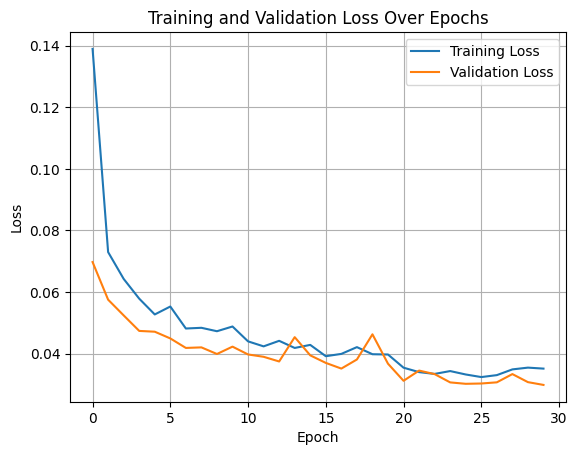

In [11]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
model = GMFN_Swin(
    in_channels=3,
    out_channels=3,
    feature_dim=256,
    num_iters=3,
    input_resolution=(64, 64)
).to(device)
checkpoint_path = "/content/drive/MyDrive/div2k/GMFN_Swin_x4_DIV2K_epoch100.pth"

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

GMFN_Swin(
  (head): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rdb): GFMRDB(
    (rdb1): ResidualDenseBlock(
      (block): Sequential(
        (0): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (1): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (2): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (3): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
      )
    )
    (rdb2): ResidualDenseBlock(
      (block): Sequential(
        (0): ConvBlock(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
        )
        (

In [9]:

# Initialize metric accumulators
psnr_sum = 0.0
ssim_sum = 0.0
fid_metric = FrechetInceptionDistance(feature=2048).to(device)  # use Inception pool3 features (2048-dim)

with torch.no_grad():
    for lr, hr in val_loader:
        lr = lr.to(device)
        hr = hr.to(device)
        # Get SR output
        sr, _ = model(lr)
        # Clamp and convert to uint8 for metrics
        sr_uint8 = (sr.clamp(0.0, 1.0) * 255).byte()
        hr_uint8 = (hr.clamp(0.0, 1.0) * 255).byte()
        # Calculate PSNR and SSIM on Y channel
        sr_img = sr_uint8[0].permute(1,2,0).cpu().numpy()  # HxWxC
        hr_img = hr_uint8[0].permute(1,2,0).cpu().numpy()
        sr_y = cv2.cvtColor(sr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
        hr_y = cv2.cvtColor(hr_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
        psnr_val = peak_signal_noise_ratio(hr_y, sr_y, data_range=255)
        ssim_val = structural_similarity(hr_y, sr_y, data_range=255)
        psnr_sum += psnr_val
        ssim_sum += ssim_val
        # Update FID metrics
        fid_metric.update(hr_uint8, real=True)
        fid_metric.update(sr_uint8, real=False)
        print(f"PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")
# Compute average PSNR, SSIM
avg_psnr = psnr_sum / len(val_dataset)
avg_ssim = ssim_sum / len(val_dataset)
# Compute FID
fid_value = fid_metric.compute().item()

print(f"Validation PSNR (Y-channel): {avg_psnr:.2f} dB")
print(f"Validation SSIM (Y-channel): {avg_ssim:.4f}")
print(f"Validation FID: {fid_value:.2f}")



PSNR: 28.61 dB, SSIM: 0.8450
PSNR: 34.40 dB, SSIM: 0.8961
PSNR: 35.42 dB, SSIM: 0.9527
PSNR: 26.59 dB, SSIM: 0.7803
PSNR: 28.15 dB, SSIM: 0.7829
PSNR: 27.48 dB, SSIM: 0.8464
PSNR: 19.88 dB, SSIM: 0.5004
PSNR: 26.07 dB, SSIM: 0.8017
PSNR: 31.75 dB, SSIM: 0.8641
PSNR: 26.13 dB, SSIM: 0.7858
PSNR: 28.39 dB, SSIM: 0.7880
PSNR: 26.42 dB, SSIM: 0.7844
PSNR: 30.03 dB, SSIM: 0.8693
PSNR: 27.22 dB, SSIM: 0.8872
PSNR: 33.49 dB, SSIM: 0.9189
PSNR: 30.56 dB, SSIM: 0.8311
PSNR: 31.26 dB, SSIM: 0.8771
PSNR: 27.58 dB, SSIM: 0.8853
PSNR: 27.46 dB, SSIM: 0.8160
PSNR: 22.96 dB, SSIM: 0.7488
PSNR: 27.49 dB, SSIM: 0.8639
PSNR: 29.12 dB, SSIM: 0.8502
PSNR: 24.99 dB, SSIM: 0.7935
PSNR: 26.45 dB, SSIM: 0.8640
PSNR: 25.91 dB, SSIM: 0.7927
PSNR: 23.34 dB, SSIM: 0.7310
PSNR: 31.40 dB, SSIM: 0.8646
PSNR: 16.71 dB, SSIM: 0.7261
PSNR: 26.27 dB, SSIM: 0.5327
PSNR: 24.25 dB, SSIM: 0.7306
PSNR: 27.95 dB, SSIM: 0.8344
PSNR: 29.33 dB, SSIM: 0.8654
PSNR: 31.90 dB, SSIM: 0.8910
PSNR: 25.08 dB, SSIM: 0.7777
PSNR: 22.56 dB

In [6]:
def plot_sr_example(lr_tensor, sr_tensor, hr_tensor, idx=None, save_path=None, crop_box=None):
    """
    מצייר את ההשוואה בין LR, SR ו-HR.

    lr_tensor: טנסור [1, 3, H, W] או [3, H, W]
    sr_tensor: טנסור [1, 3, H, W] או [3, H, W]
    hr_tensor: טנסור [1, 3, H, W] או [3, H, W]
    idx: אינדקס להצגה בכותרת (אופציונלי)
    save_path: אם יש נתיב, ישמור לשם את האיור כ־PNG
    crop_box: tuple (left, upper, right, lower) – לחיתוך אזור ספציפי להשוואה
    """
    def tensor_to_np(t):
        if t.dim() == 4:
            t = t[0]
        img = t.cpu().clamp(0, 1).permute(1, 2, 0).numpy()
        return (img * 255).astype(np.uint8)

    lr = tensor_to_np(lr_tensor)
    sr = tensor_to_np(sr_tensor)
    hr = tensor_to_np(hr_tensor)

    if crop_box:
        lr = TF.crop(TF.to_pil_image(torch.tensor(lr).permute(2, 0, 1).float() / 255), *[c//4 for c in crop_box])
        sr = TF.crop(TF.to_pil_image(torch.tensor(sr).permute(2, 0, 1).float() / 255), *crop_box)
        hr = TF.crop(TF.to_pil_image(torch.tensor(hr).permute(2, 0, 1).float() / 255), *crop_box)
        lr = np.array(lr)
        sr = np.array(sr)
        hr = np.array(hr)

    titles = ['Low-Resolution (LR)', 'Super-Resolved (SR)', 'High-Resolution (HR)']
    images = [lr, sr, hr]

    plt.figure(figsize=(12, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(title, fontsize=14)
        plt.axis('off')
    if idx is not None:
        plt.suptitle(f"Example #{idx}", fontsize=16)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

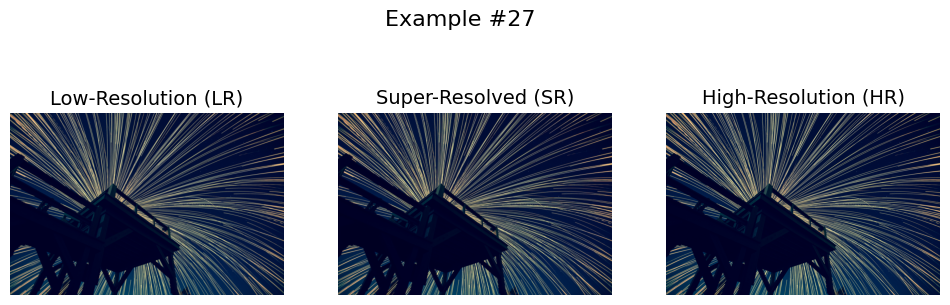

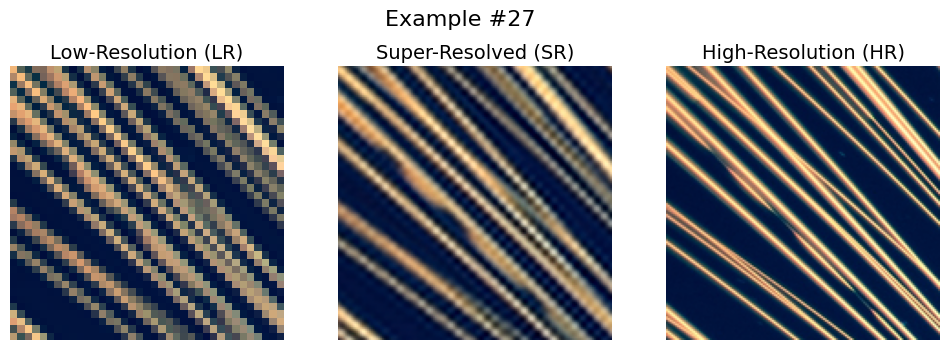

In [12]:
lr, hr = val_dataset[27]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

plot_sr_example(lr, sr_final, hr, idx=27)
crop_box = (100, 100, 150, 150)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=27, crop_box=crop_box)

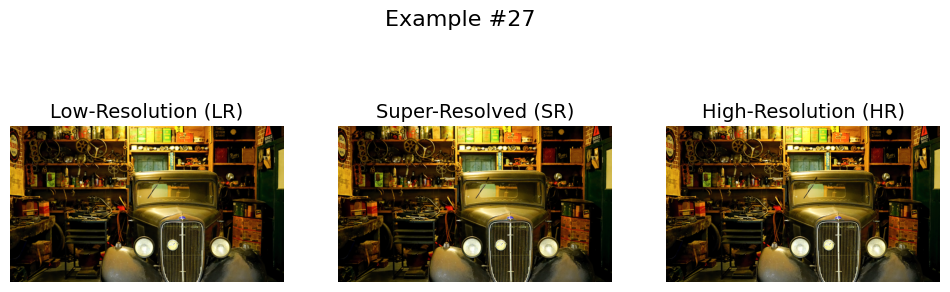

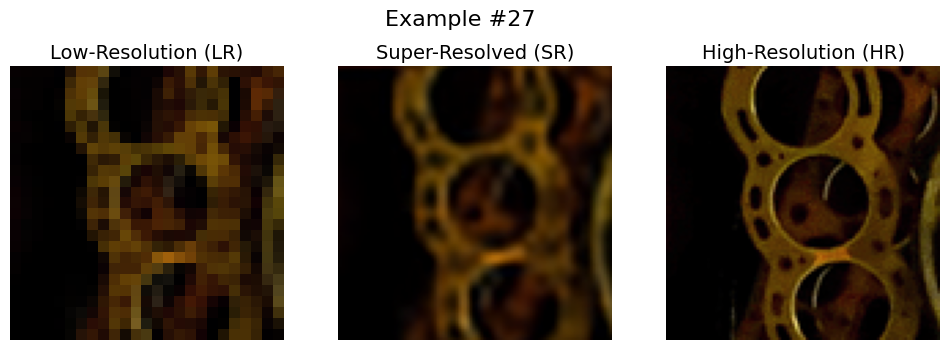

In [15]:
lr, hr = val_dataset[99]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

plot_sr_example(lr, sr_final, hr, idx=27)
crop_box = (120, 120, 100, 100)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=27, crop_box=crop_box)

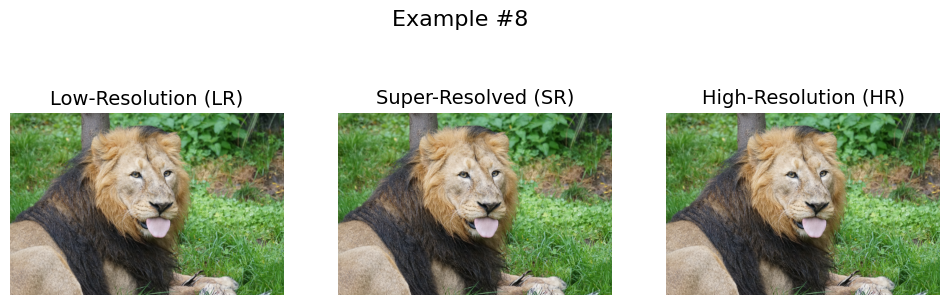

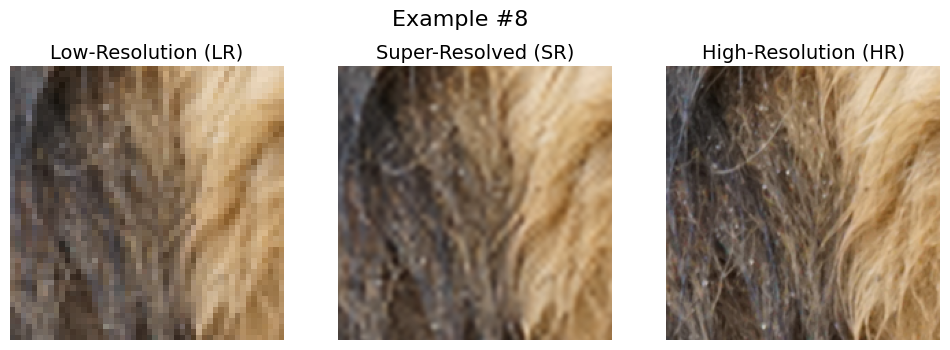

In [11]:
lr, hr = val_dataset[8]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

plot_sr_example(lr, sr_final, hr, idx=8)
crop_box = (500, 500, 200, 200)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=8, crop_box=crop_box)

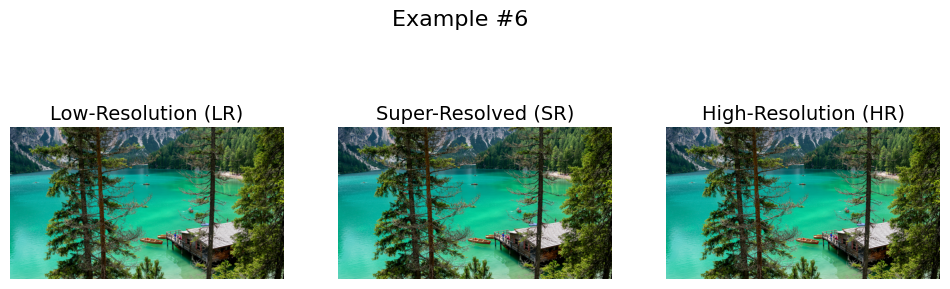

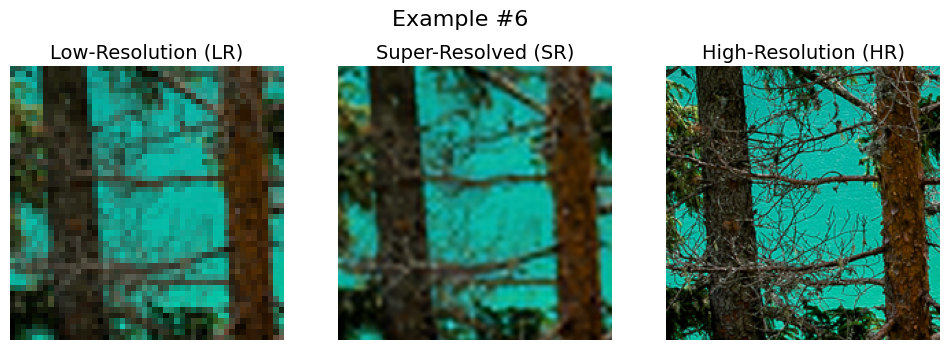

In [12]:
lr, hr = val_dataset[6]
lr = lr.unsqueeze(0).to(device)   # [1, 3, H, W]
hr = hr.unsqueeze(0).to(device)   # [1, 3, H, W]

# הפעלת המודל
with torch.no_grad():
    sr_final, _ = model(lr)

plot_sr_example(lr, sr_final, hr, idx=6)
crop_box = (500, 500, 200, 200)  # left, top, right, bottom ב-HR
plot_sr_example(lr, sr_final, hr, idx=6, crop_box=crop_box)